# Transfer Learning mit Pretrained CNNs

In [1]:
import pathlib

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

In [46]:
def plot_example_image(dataset, _classes):
    for X, y in dataset.shuffle(10000):

        f, axes = plt.subplots(3, 3, figsize=(7,7))

        for i, ax in enumerate(axes.flatten()):
            plottable_image = X[i].numpy() / 255
            ax.imshow(plottable_image)
            ax.set_title(_classes[y[i]])

        f.tight_layout()
        plt.show()

        break

In [3]:
def plot_epochs(history, history2=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    if history2:
        acc += history2.history['accuracy']
        val_acc += history2.history['val_accuracy']
        loss += history2.history['loss']
        val_loss += history2.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

## Data loading and preparation

Daten werden nach Download in .keras directory abgelegt

In [4]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [5]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

## Aufgabe 1.)
Wenn möglich, schau dir die Ordnerstruktur an, in der das flower_photos Datenset gespeichert ist und gib sie aus (optional)

In [6]:
print("Directory Structure:")
!ls $data_dir

Directory Structure:
daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


In [7]:
flower_dir = "daisy"
print(f"Number of files in directory {flower_dir}:")

!ls $data_dir/$flower_dir | wc -l

Number of files in directory daisy:
633


## Aufgabe 2.)

Lade das Datenset von der Festplatte mit  `tf.keras.utils.image_dataset_from_directory` und erstelle Train- und Validation-Dataset.<br>
Achte dabei darauf den `validation_split`, `image_size`, `seed` und `batch_size` mit anzugeben.

In [8]:
batch_size = 128
img_width = 224
img_height = img_width

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 734 files for validation.


### Zur Optimierung des Datenladens

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


### Ausgeben einzelner Beispielbilder

In [12]:
classes = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]


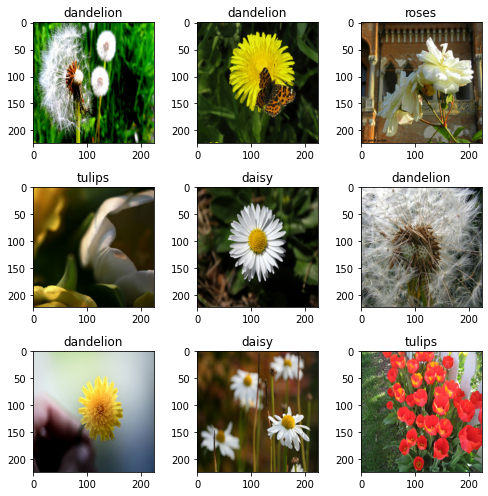

In [47]:
plot_example_image(train_ds, classes)

## Aufgabe 3.) Erstelle nun das Modell 

Wähle ein Passendes (nicht zu groß) aus den Keras Application Modellen aus https://keras.io/api/applications/.<br>
Achte dabei genau auf die Beschreibung, in der erklärt wird, wie das Preprocessing durchgeführt werden sollte.<br>
Da wir nicht ImageNet sondern das Flower Datenset klassifiziern, sollten wir `include_top=False` wählen und entsprechend einen neuen Classification Head hinzufügen<br>
Entscheide ob du das Modell nur mit Feature Extraction oder/und finetunen möchtest und passe entsprechend das `trainable` Attribut jeder Layer an.<br>
Zu letzt, compile das Modell mit entsprechenden Optimizer, Loss und Metrik und fitte es dann. Speichere dabei die history in einem Objekt um später den Trainingsverlauf zu plotten.<br>
Optional: 
- Hinzufügen einer Augmentation Layer mit z.B `keras.layers.RandomFlip`, ...
- Hinzufügen von Callbacks wie z.B. `keras.callbacks.EarlyStopping`, ...


### Model

In [14]:
num_classes = len(classes)
learning_rate = 0.01

In [15]:
data_augmentation = tf.keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical", seed=42),
    keras.layers.RandomRotation(factor=0.05, seed=42),
    keras.layers.RandomContrast(factor=0.2, seed=42)
  ], name="augmentation")

In [16]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, min_delta=0.0001, restore_best_weights=True)

In [17]:
image_shape = (img_height, img_width, 3)
efficient_net_v2b0 = tf.keras.applications.EfficientNetV2B0(input_shape=image_shape, include_top=False, weights='imagenet')

### Feature Extraction

In [18]:
# feature extraction
for layer in efficient_net_v2b0.layers:
    layer.trainable = False

In [19]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(img_height, img_width, 3), name="input"))
model.add(keras.layers.Resizing(img_height, img_width, name="resizing"))
model.add(data_augmentation)
model.add(efficient_net_v2b0)
model.add(keras.layers.GlobalAveragePooling2D(name="pooling"),)
model.add(keras.layers.Dropout(0.2, name="dropout"))
model.add(keras.layers.Dense(num_classes, name="classification_dense"))

In [20]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 augmentation (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 pooling (GlobalAveragePooli  (None, 1280)             0         
 ng2D)                                                           
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 classification_dense (Dense  (None, 5)                6

In [22]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[es_callback]
)

Epoch 1/10


23/23 [==============================] - 59s 2s/step - loss: 0.5794 - accuracy: 0.7813 - val_loss: 0.2990 - val_accuracy: 0.9060
Epoch 2/10
23/23 [==============================] - 40s 2s/step - loss: 0.2729 - accuracy: 0.8988 - val_loss: 0.2503 - val_accuracy: 0.9196
Epoch 3/10
23/23 [==============================] - 39s 2s/step - loss: 0.2142 - accuracy: 0.9223 - val_loss: 0.2321 - val_accuracy: 0.9264
Epoch 4/10
23/23 [==============================] - 40s 2s/step - loss: 0.1823 - accuracy: 0.9356 - val_loss: 0.2207 - val_accuracy: 0.9373
Epoch 5/10
23/23 [==============================] - 39s 2s/step - loss: 0.1635 - accuracy: 0.9418 - val_loss: 0.2320 - val_accuracy: 0.9319
Epoch 6/10
23/23 [==============================] - 39s 2s/step - loss: 0.1492 - accuracy: 0.9469 - val_loss: 0.2343 - val_accuracy: 0.9305
Epoch 7/10
23/23 [==============================] - 39s 2s/step - loss: 0.1362 - accuracy: 0.9554 - val_loss: 0.2160 - val_accuracy: 0.9387
Epoch 8/10
23/23 [=============

### Fine Tuning

In [23]:
len(efficient_net_v2b0.layers)

270

In [24]:
# fine tuning
efficient_net_v2b0.trainable = True
for i, layer in enumerate(efficient_net_v2b0.layers):
    if i < 200:
        layer.trainable = False

learning_rate_ft = 0.1 * learning_rate

In [25]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate_ft),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 augmentation (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 pooling (GlobalAveragePooli  (None, 1280)             0         
 ng2D)                                                           
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 classification_dense (Dense  (None, 5)                6

In [27]:
ft_epochs=10
total_epochs = history.epoch[-1] + ft_epochs
history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=[es_callback]
)

Epoch 10/19


23/23 [==============================] - 62s 2s/step - loss: 0.2448 - accuracy: 0.9162 - val_loss: 0.1967 - val_accuracy: 0.9346
Epoch 11/19
23/23 [==============================] - 40s 2s/step - loss: 0.0732 - accuracy: 0.9768 - val_loss: 0.1865 - val_accuracy: 0.9401
Epoch 12/19
23/23 [==============================] - 40s 2s/step - loss: 0.0341 - accuracy: 0.9901 - val_loss: 0.2045 - val_accuracy: 0.9428
Epoch 13/19
23/23 [==============================] - 39s 2s/step - loss: 0.0188 - accuracy: 0.9949 - val_loss: 0.2217 - val_accuracy: 0.9401
Epoch 14/19
23/23 [==============================] - 39s 2s/step - loss: 0.0188 - accuracy: 0.9946 - val_loss: 0.2430 - val_accuracy: 0.9414


## Aufgabe 4.)

Nachdem das Modell trainiert ist, plotte jeweils 'accuracy', 'val_accuracy', 'loss' und 'val_loss' aus dem `history` Objekt 

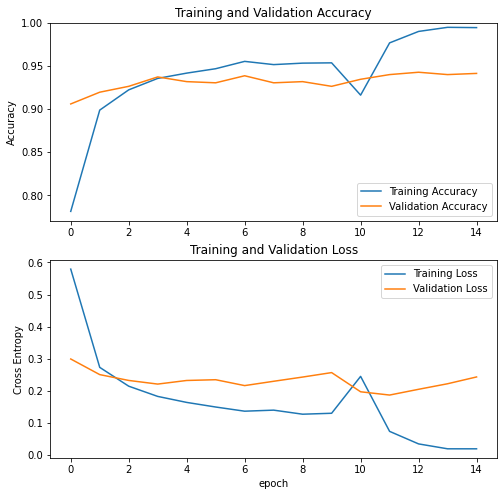

In [28]:
plot_epochs(history, history_ft)

## Aufgabe 5.)

Gib die Accuracy auf das Validation Set aus. Wie schätzt du die Leistung des Modells ein?

In [29]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4} \t Validation Accuracy: {val_acc:.4}")

6/6 [==============================] - 1s 171ms/step - loss: 0.1865 - accuracy: 0.9401
Validation Loss: 0.1865 	 Validation Accuracy: 0.9401
